In [1]:
import re
from textblob import TextBlob
import nltk
import json
import pandas 
import csv


In [2]:
from collections import Counter
import io
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [3]:
import gensim.models as w2v
import sklearn.decomposition as dcmp
import scipy.cluster.hierarchy as hcluster

In [4]:
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [5]:
def applyRegexps(text, listRegExp):
    """ Applies successively many regexps to a text"""
    for element in listRegExp:
        left = element['expr']
        right = element['subs']
        r=re.compile(left)
        text=r.sub(right,text)
    return text

def detex(latexText):
    """Transform a latex text into a simple text"""    
    regexps=[]
    text=latexText
    # remove all the contents of the header, ie everything before the first occurence of "\begin{document}"
    text = re.sub(r"(?s).*?(\\begin\{document\})", " ", text, 1)
    
    # remove comments
    regexps.append({r'expr':r'([^\\])%.*', 'subs':r'\1 '})
    text= applyRegexps(text, regexps)
    regexps=[]
    text = text.replace("\n", " ")
    # - replace some LaTeX commands by the contents inside curly rackets
    
    q = re.compile(r'\$\$(.*?)\$\$')
    text = re.sub(q, ' ', text)
    r = re.compile(r'\$(.*?)\$')
    text = re.sub(r, ' ', text)
    text = text.replace("\index", " ")
    
    r = re.compile(r'\\begin{equation}(.*?)\\end{equation}')
    text = re.sub(r, ' ', text)
    
    
    to_reduce = [r'\\emph', r'\\textbf', r'\\textit', r'\\text', r'\\IEEEauthorblockA', 
                 r'\\IEEEauthorblockN', r'\\author', r'\\caption', r'\\thanks']
    for tag in to_reduce:
      regexps.append({'expr':tag+r'\{([^\}\{]*)\}', 'subs':r' \1 '})
    text= applyRegexps(text, regexps)
    regexps=[]

    # - replace some LaTeX commands by the contents inside curly brackets and highlight these contents
    to_highlight = [r'\\part[\*]*', r'\\chapter[\*]*', r'\\section[\*]*', r'\\subsection[\*]*', 
                    r'\\subsubsection[\*]*', r'\\paragraph[\*]*'];
    # highlightment pattern: #--content--#
    for tag in to_highlight:
      regexps.append({'expr':tag+r'\{([^\}\{]*)\}','subs':r'\n\1 \n'})
    # highlightment pattern: [content]
    to_highlight = [r'\\title',r'\\author',r'\\thanks',r'\\cite', r'\\ref'];
    for tag in to_highlight:
      regexps.append({'expr':tag+r'\{([^\}\{]*)\}','subs':r'\1 '})
    text= applyRegexps(text, regexps)
    regexps=[]
    

    # remove LaTeX tags
    # - remove completely some LaTeX commands that take arguments
    to_remove = [r'\\vspace', r'\\medskipamount', r'\\hspace', r'\\tableofcontents', r'\\noindent',
                 r'\\maketitle',r'\\footnote', r'\\centering', r'\\IEEEpeerreviewmaketitle', r'\\Large',
                 r'\\includegraphics', r'\\IEEEauthorrefmark', r'\\label', r'\\begin', r'\\maketitle',
                 r'\\end', r'\\big', r'\\right', r'\\left', r'\\documentclass', 
                 r'\\usepackage', r'\\bibliographystyle', r'\\bibliography',  
                 r'\\cline', r'\\multicolumn', r'\\printindex', r'\\makeindex', r'\\small', r'\\title',
                 r'\\author', r'\\thanks', r'\\cite', r'\\ref', r'\\today', r'\\date', r'\\inde',
                 r'\\bdf', r'\\edf', r'\\tt', r'\\ece', r'\\bce', r'\\la', r'\\ete', r'\\od', r'\\par',
                 r'\\ebla', r'\\dd', r'\\d', r'\\ls', r'\\ubf', r'\\ble', r'\\od\\', r'\\ri', r'\\ls_', r'\\ga',
                 r'\\ti', r'\\vom', r'\\textwidth', r'\\itl', r'\\bf', r'\\vy', r'\\een', r'\\ri ', r'\\rit',
                 r'\\snos', r'\\plo', r'\\bte', r'\\rod', r'\\ele', r'\\bpf', r'\\epf', r'\\bbla', r'\\en', r'\\vpi',
                 r'\\ben', r'\\nenu', r'\\renu', r'\\bcor', r'\\text', r'\\it', r'\\fenu', r'\\atc', r'\\bpn', 
                 r'\\trn', r'\\bpro', r'\\epro', r'\\ep', r'\\ima', r'\\ecor', r'\\pagebreak', r'\\qed', r'\\t',
                 r'\\qe', r'\\bco', r'\\evo', r'\\rm', r'\\ata', r'\\em', r'\\index' ]
    
    # replace tag with options and argument by a single space
    for tag in to_remove:
      regexps.append({'expr':tag+r'(\[[^\]]*\])*(\{[^\}\{]*\})*', 'subs':r' '})
    text= applyRegexps(text, regexps)
    regexps=[]

    
    # - replace some LaTeX commands by the contents inside curly rackets
    # replace some symbols by their ascii equivalent
    # - common symbols
    regexps.append({'expr':r'\\eg(\{\})* *','subs':r'e.g., '})
    regexps.append({'expr':r'\\ldots','subs':r' '})
    regexps.append({'expr':r'\\Rightarrow','subs':r' '})
    regexps.append({'expr':r'\\rightarrow','subs':r' '})
    regexps.append({'expr':r'\\le','subs':r' '})
    regexps.append({'expr':r'\\ge','subs':r' '})
    regexps.append({'expr':r'\\_','subs':r' '})
    regexps.append({'expr':r'\\\\','subs':r'\n'})
    regexps.append({'expr':r'~','subs':r' '})
    regexps.append({'expr':r'\\&','subs':r' '})
    regexps.append({'expr':r'\\%','subs':r' '})
    regexps.append({'expr':r'([^\\])&','subs':r' \1\t'})
    regexps.append({'expr':r'\\item','subs':r' \t- '})
    #regexps.append({'left':r'\\\hline[ \t]*\\hline','right':r'============================================='})
    #regexps.append({'left':r'[ \t]*\\hline','right':r'_____________________________________________'})
    # - special letters
    regexps.append({'expr':r'\\\'{?\{e\}}?','subs':r'é'})
    regexps.append({'expr':r'\\`{?\{a\}}?','subs':r'à'})
    regexps.append({'expr':r'\\\'{?\{o\}}?','subs':r'ó'})
    regexps.append({'expr':r'\\\'{?\{a\}}?','subs':r'á'})
    # keep untouched the contents of the equations
    regexps.append({'expr':r'\$(.)\$', 'subs':r''})
    regexps.append({'expr':r'\$([^\$]*)\$', 'subs':r''})
    # remove the equation symbols ($)
    regexps.append({'expr':r'([^\\])\$', 'subs':r''})
    # correct spacing problems
    regexps.append({'expr':r' +,','subs':r' '})
    regexps.append({'expr':r' +','subs':r' '})
    regexps.append({'expr':r' +\)','subs':r' '})
    regexps.append({'expr':r'\( +','subs':r' '})
    regexps.append({'expr':r' +\.','subs':r' '})    
    # remove lonely curly brackets    
    regexps.append({'expr':r'^([^\{]*)\}', 'subs':r' \1 '})
    regexps.append({'expr':r'([^\\])\{([^\}]*)\}','subs':r' \1\2 '})
    regexps.append({'expr':r'\\\{','subs':r' '})
    regexps.append({'expr':r'\\\}','subs':r' '})
    # strip white space characters at end of line
    regexps.append({'expr':r'[ \t]*\n','subs':r'\n'})
    # remove consecutive blank lines
    regexps.append({'expr':r'([ \t]*\n){3,}','subs':r'\n'})
    # apply all those regexps
    text= applyRegexps(text, regexps)
    regexps=[]    
    # return the modified text
    text = re.sub( '[":$#&!(){}\/,^*`~=+_@;?]', ' ', text )
    text = text.replace("'"," ").replace("["," ").replace("]"," ")
    return text

latexText= r"""
    \begin{document}
    \title{Next Generation Networks}
    \author{Tot titi\thanks{Network and Security -- test company -- toto@ieee.org}}
    \maketitle
    \begin{abstract}\footnote{Version :  \today ;  \now}
    lorem ipsum(\ldots)\end{abstract}
    \end{document}"""
text=detex(latexText)






In [6]:
f = open('/Users/pradeepkumarnama/Desktop/CSE519-2017-Project-master2/Tex_Files/1.txt')
lines = f.readlines()
f.close()

original = ""
for line in lines:
    original += line


In [7]:
def remove_stop_words(words):
        return [w for w in words if not w in nltk.corpus.stopwords.words('english')]

In [8]:
finalText=detex(original)
print(finalText)
finalText = finalText.replace('\\', '')
finalText = finalText.replace('\\', '')
finalText = finalText.replace('\\', '')
finalText = re.sub(' +',' ',finalText)
finalText = finalText.replace('.', '\n')

finalText1 = ''.join(finalText)
lines = finalText.split("\n")
lines1 = remove_stop_words(lines)

sentence = []

for i in range(len(lines)):
    sentence.append(lines1[i].split(" "))
print(sentence)


  OD elements of countable OD sets in the Solovay model     Vladimir Kanovei  IITP RAS and MIIT  Moscow  Russia  \   kanovei googlemail.com  --- contact author.         It is true in the Solovay model that every countable ordinal-definable set of sets of reals contains only ordinal-definable elements.  fIntroduction   scha1  It is known that the existence of a non-empty  ordinal-definable  set of reals with no \ element is consistent with   the set of all non-constructible reals gives a transparent example in many generic models.  tCan such a set\  be countable   This question was initiated and discussed at the  tMathoverflow  website   t Mathoverflow   March 09  2010.   http   mathoverflow.net questions 17608 .   and at FOM   FOM Jul 23  2010.   http   cs.nyu.edu pipermail fom 2010-July 014944.html    In particular Ali Enayat  Footnote snos2  conjectured that the problem can be solved by the finite-support countable product  see ena  of the Jensen   minimal real singleton forcing   de

In [9]:


#print(wordsmodel.wv.save_word2vec_format('model.bin'))

In [11]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    words = remove_stop_words(words)
    count = [['UNK', -1]]
    count.extend(Counter(words).most_common(n_words - 1))
    dictionary = {}
    for word, _ in count:
        if len(word)>=4:
            dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count

    return dictionary

In [13]:
model = gensim.models.Word2Vec(sentence, min_count=10)
words = list(model.wv.vocab)

2017-12-04 00:51:58,319 : INFO : collecting all words and their counts
2017-12-04 00:51:58,321 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-04 00:51:58,324 : INFO : collected 902 word types from a corpus of 5092 raw words and 121 sentences
2017-12-04 00:51:58,325 : INFO : Loading a fresh vocabulary
2017-12-04 00:51:58,328 : INFO : min_count=10 retains 90 unique words (9% of original 902, drops 812)
2017-12-04 00:51:58,329 : INFO : min_count=10 leaves 3509 word corpus (68% of original 5092, drops 1583)
2017-12-04 00:51:58,331 : INFO : deleting the raw counts dictionary of 902 items
2017-12-04 00:51:58,333 : INFO : sample=0.001 downsamples 90 most-common words
2017-12-04 00:51:58,335 : INFO : downsampling leaves estimated 1250 word corpus (35.6% of prior 3509)
2017-12-04 00:51:58,336 : INFO : estimated required memory for 90 words and 100 dimensions: 117000 bytes
2017-12-04 00:51:58,337 : INFO : resetting layer weights
2017-12-04 00:51:58,341 : INFO 

In [14]:
dict1 = {}
dict1 = build_dataset(words, 100)
dict1 = sorted(dict1)
list_form = list(dict1)
print(list_form)


        

['Assume', 'Lemma', 'Solovay', 'Then', 'Theorem', 'Therefore', 'Thus', 'also', 'assume', 'belongs', 'condition', 'containing', 'contains', 'countable', 'definition', 'dense', 'double-name', 'double-names', 'equivalent', 'follows', 'forces', 'forcing', 'full', 'generic', 'hence', 'model', 'name', 'names', 'pair', 'proof', 'prove', 'reals', 'regular', 'satisfying', 'sets', 'since', 'still', 'theorem', 'true']


In [154]:
thefile = open('/Users/pradeepkumarnama/Desktop/CSE519-2017-Project-master2/word_embedding/11.txt', 'w')

for item in list_form:
    thefile.write("%s\n" %item)

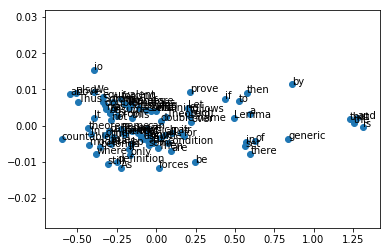

In [15]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = model.wv.vocab
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.figure(figsize = (300,300))
pyplot.show()


In [16]:
def evaluate( test, actual ):
    with open(actual) as fin:
        d = {}
        i_list=[]
        for line in fin:
            i_list.append(line)

    #print(i_list)
    num_lines = sum(1 for line in open(test))
    num_lines_OF=sum(1 for line in open(actual))

    print("actual indices ", num_lines_OF)
    print("predicted indices ", num_lines)

    trials = 15
    num_indices_list = [25, 50, 75, 100,125,150,175,200, 225, 250, 275, 300, 325, 350, 400]
    mylist=[]
    mylist1=[]
    for i in range(0,trials):
        count=0
        num = num_indices_list[i]
        mylist1.append(i+1)
        with open(test) as fin1:
            for j in range(0, num):
                line=fin1.readline()
                if line in i_list :
                    count=count+1
                    
        #print('Number of matches:' , count)
        if num < num_lines_OF:
            percentage = int(count*100/num)
        else:
            percentage = int(count*100/num_lines_OF)
        mylist.append(percentage)
        if i>=5 :
            print('Number of matches:' , count)
            print('Percentage Matched: ', percentage)
            pyplot.figure(figsize=(20,10))
            pyplot.xlabel('Number of Trials')
            pyplot.ylabel('Percentage match')
            pyplot.bar(mylist1, mylist, width=0.3)
            pyplot.show()

actual indices  130
predicted indices  82
Number of matches: 29
Percentage Matched:  22


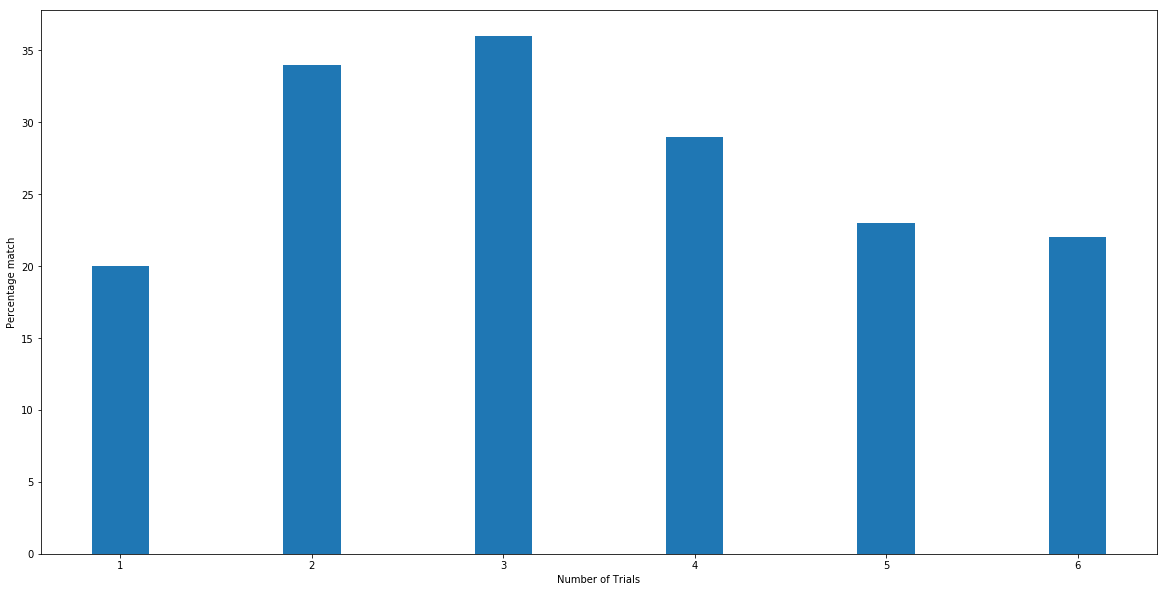

Number of matches: 29
Percentage Matched:  22


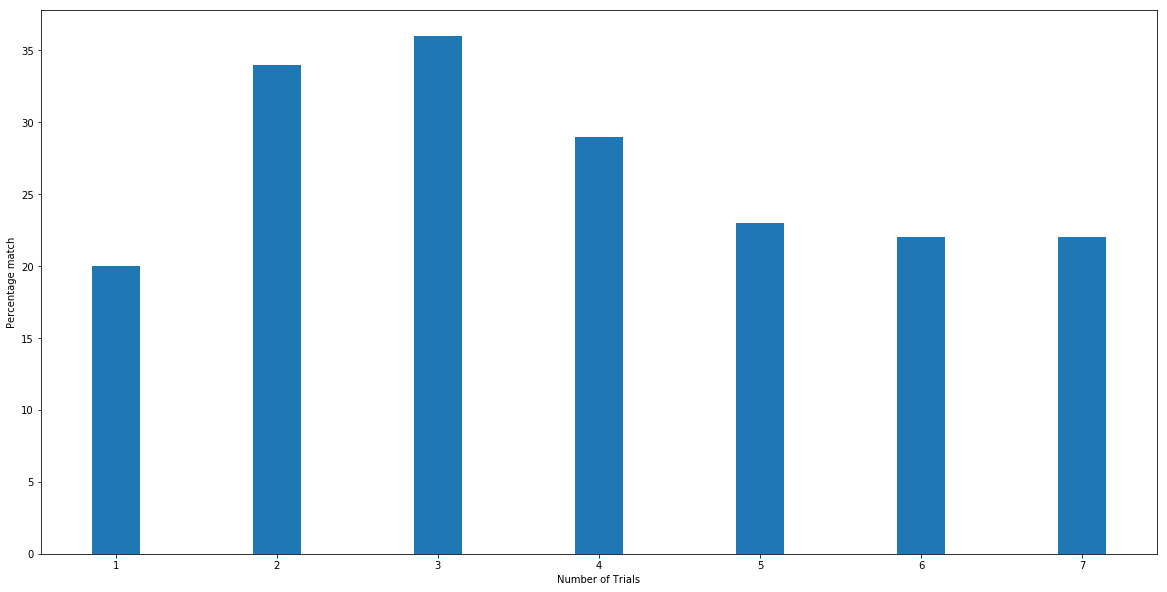

Number of matches: 29
Percentage Matched:  22


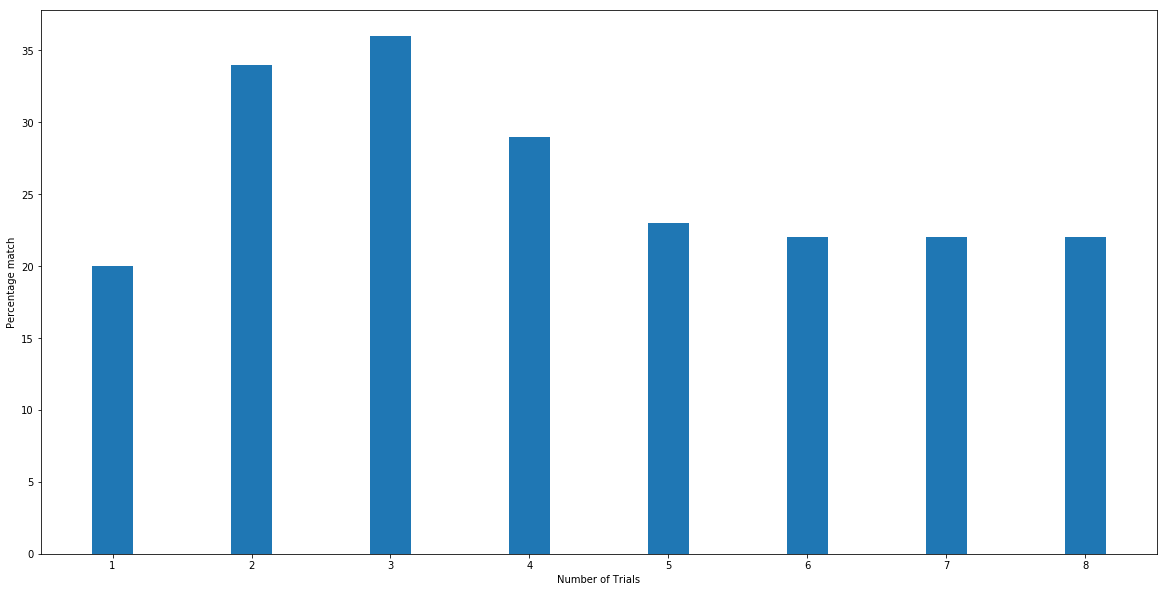

Number of matches: 29
Percentage Matched:  22


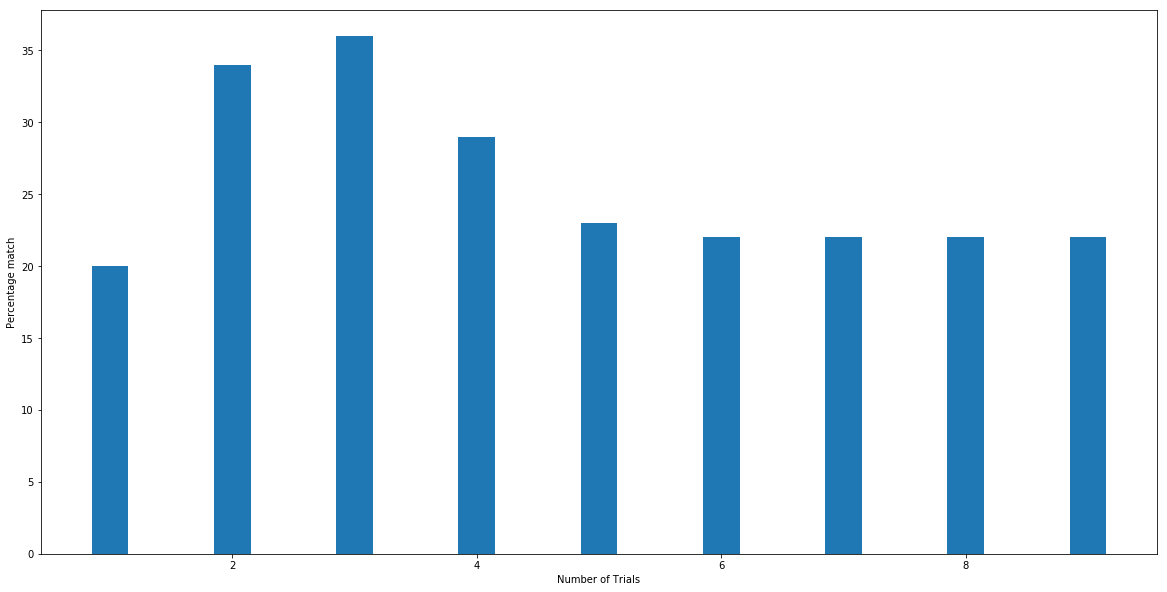

Number of matches: 29
Percentage Matched:  22


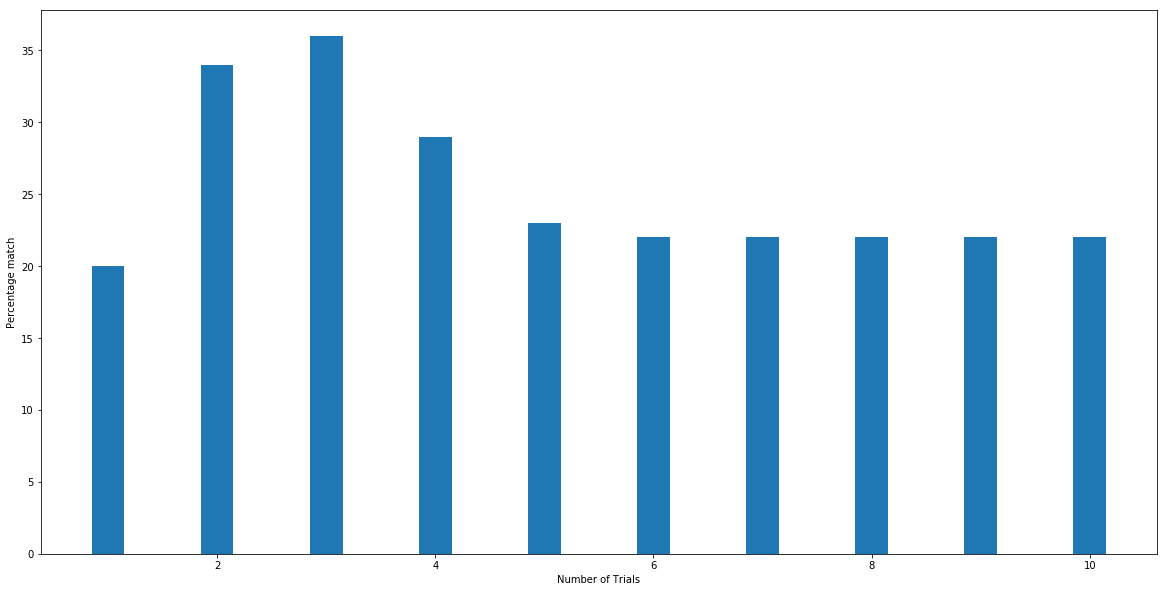

Number of matches: 29
Percentage Matched:  22


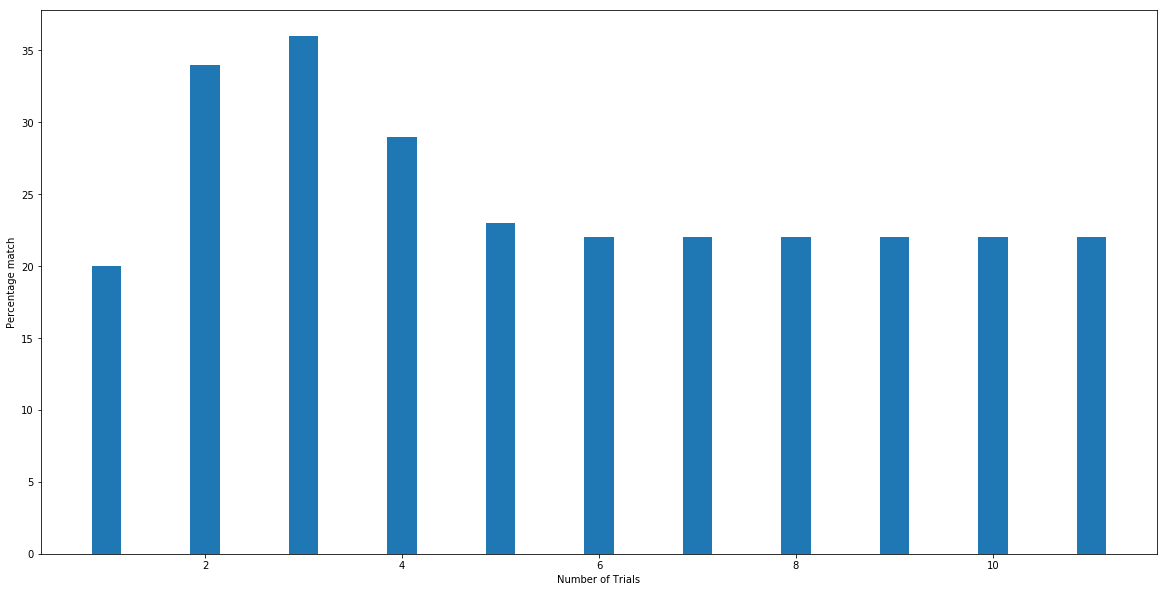

Number of matches: 29
Percentage Matched:  22


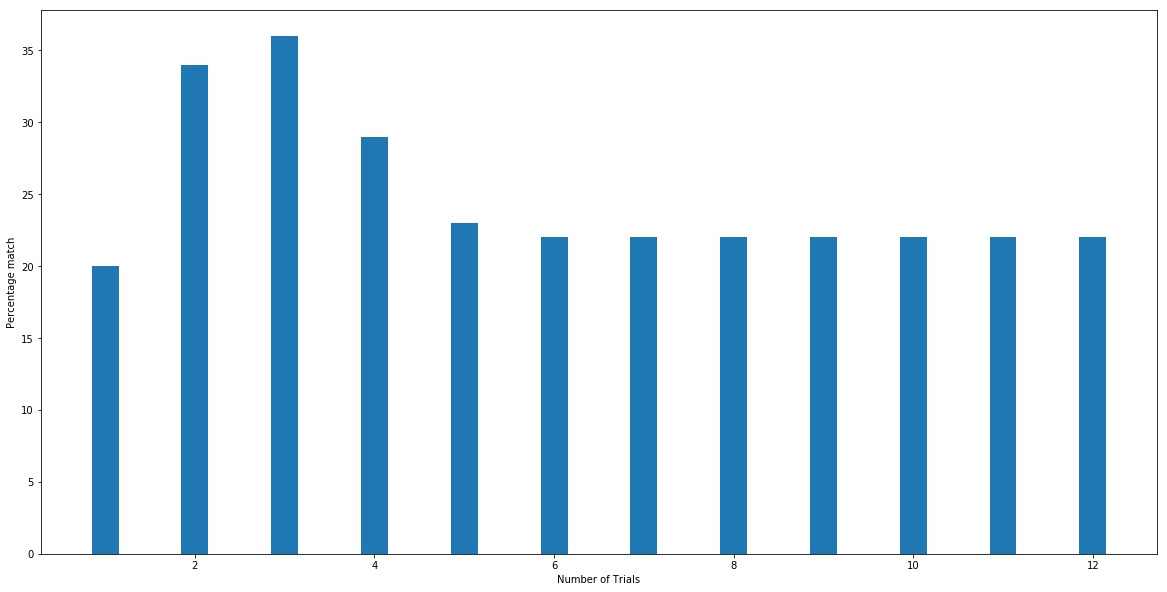

Number of matches: 29
Percentage Matched:  22


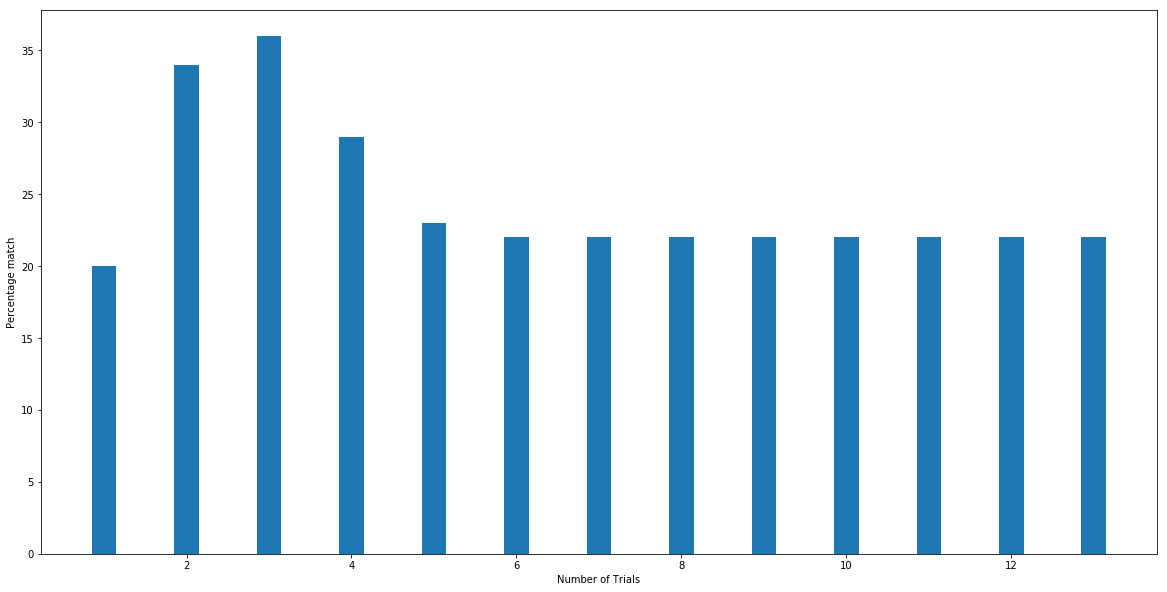

Number of matches: 29
Percentage Matched:  22


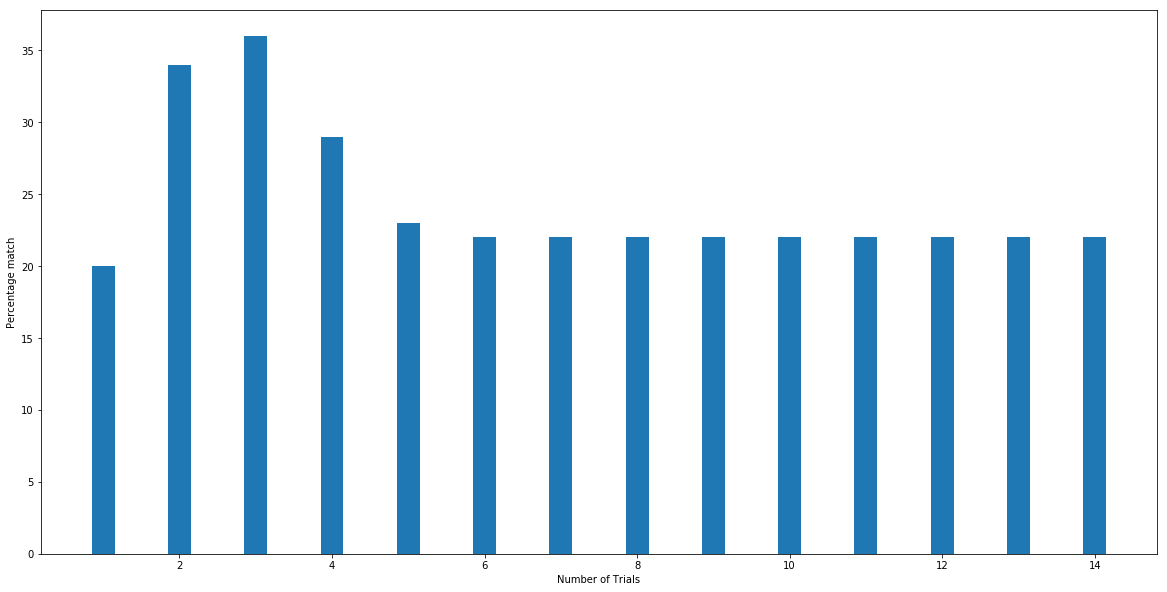

Number of matches: 29
Percentage Matched:  22


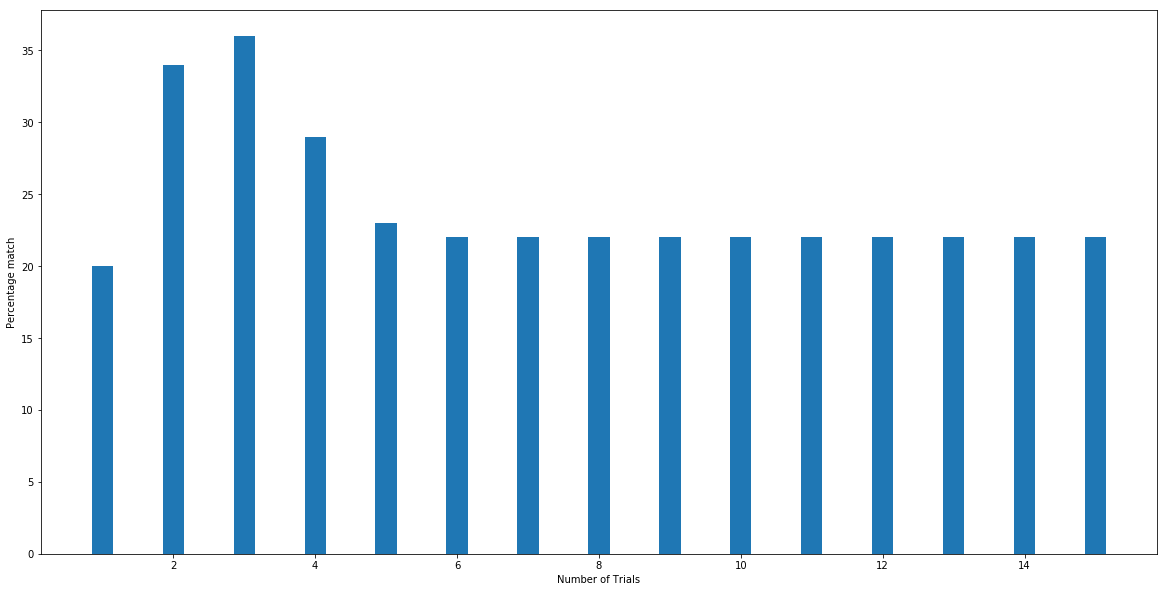

In [17]:
evaluate('/Users/pradeepkumarnama/Desktop/CSE519-2017-Project-master2/word_embedding/9.txt','/Users/pradeepkumarnama/Desktop/CSE519-2017-Project-master2/Indices_Original/9_words.txt')